# NEL (Negative Binomial Empirical Laplace) — CRISPR Screen Pipeline

Workflow: install → I/O paths → helpers → data & QC → EB calibration → IRLS + Laplace → diagnostics → hit-calling → volcano plots.

This notebook mirrors the structure of the HBM NUTS pipeline but implements a fast per-gene Laplace approximation with EB-calibrated priors.

## 1) Imports and global config

In [41]:
from __future__ import annotations
import os
from pathlib import Path
import json
import math

import numpy as np
import pandas as pd
from scipy import linalg, stats
import statsmodels.api as sm
from sklearn.utils import check_random_state

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

az.style.use('arviz-docgrid')
sns.set_context('notebook')
sns.set_style('whitegrid')
pd.options.display.max_columns = 120
pd.options.display.width = 160
np.set_printoptions(suppress=True, linewidth=140)

## 2) I/O paths

In [2]:
# Resolve repo root relative to this notebook
NB_PATH = Path.cwd()
# If running from a different CWD, set REPO_ROOT manually
REPO_ROOT = NB_PATH.parents[1]
DATA_DIR = REPO_ROOT / 'data'
OUT_DIR = REPO_ROOT / 'outputs'
OUT_TABLES = OUT_DIR / 'tables'
OUT_FIGS = OUT_DIR / 'figures'

OUT_TABLES.mkdir(parents=True, exist_ok=True)
OUT_FIGS.mkdir(parents=True, exist_ok=True)

# Preferred tidy input (if produced upstream):
TIDY_COUNTS = OUT_TABLES / 'tidy_counts.csv'
NEL_SUMMARY_CSV = OUT_TABLES / 'nel_gene_summary.csv'
NEL_HITS_CSV = OUT_TABLES / 'hits_nel.csv'
NEL_PRIORS_JSON = OUT_TABLES / 'global_params_priors.json'  # shared with HBM flow if desired

## 3) Helper functions

In [3]:
def ensure_columns(df: pd.DataFrame, cols: list[str]):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f'Missing required columns: {missing}')

def center_treatment(x: pd.Series) -> pd.Series:
    # Center {0,1} to { -0.5, +0.5 } for balanced design
    x = x.astype(float)
    return x - x.mean()

def compute_base_mean(df: pd.DataFrame) -> pd.Series:
    # Use size-factor normalization then average per gene
    y_sf = df['count'] / df['size_factor']
    bm = y_sf.groupby(df['gene']).mean()
    return bm

def derive_x_from_condition(d: pd.DataFrame, mapping: dict | None = None) -> tuple[pd.Series, dict]:
    if 'x' in d.columns:
        return d['x'].astype(int), {'provided': True}
    if 'condition' not in d.columns:
        raise ValueError("Missing treatment indicator: provide 'x' or 'condition' column")
    cond = d['condition'].astype(str)
    levels = sorted(cond.unique().tolist())
    if mapping is not None:
        x = cond.map(mapping)
        if x.isna().any():
            missing = sorted(set(cond[x.isna()].unique()))
            raise ValueError(f'Condition mapping missing keys: {missing}')
        return x.astype(int), mapping
    aliases0 = {'control','ctrl','vehicle','untreated','baseline'}
    aliases1 = {'treatment','treated','drug','perturb','case'}
    m = {}
    for lv in levels:
        key = lv.strip().lower()
        if key in aliases0: m[lv] = 0
        elif key in aliases1: m[lv] = 1
    if len(m) == 2:
        return cond.map(m).astype(int), m
    # fallback: sorted order
    m = {levels[0]: 0, levels[1]: 1}
    return cond.map(m).astype(int), m

def prepare_long_df(df: pd.DataFrame) -> pd.DataFrame:
    # Standardize schema and add derived columns
    base_cols = ['gene', 'sgrna', 'sample_id', 'count', 'size_factor']
    ensure_columns(df, base_cols)
    d = df.copy()
    x_series, _ = derive_x_from_condition(d)
    d['x'] = x_series.astype(int)
    d['x_tilde'] = center_treatment(d['x'])
    d['offset'] = np.log(d['size_factor'].astype(float) + 1e-12)
    return d

def maybe_load_tidy_counts(path: Path) -> pd.DataFrame | None:
    if path.exists():
        df = pd.read_csv(path)
        return df
    return None

def synthesize_dataset(n_genes: int = 200, n_sgrna: int = 4, n_samples: int = 8,
                       effect_frac: float = 0.1, rng=42) -> pd.DataFrame:
    rs = check_random_state(rng)
    genes = [f'g{i:04d}' for i in range(n_genes)]
    sgrnas = [f'sg{j:02d}' for j in range(n_sgrna)]
    samples = [f's{i:02d}' for i in range(n_samples)]
    x = np.array([0]*(n_samples//2) + [1]*(n_samples - n_samples//2))
    size_factor = rs.lognormal(mean=0.0, sigma=0.2, size=n_samples)
    phi = 20.0  # moderate overdispersion
    beta = np.zeros(n_genes)
    ix = rs.choice(n_genes, int(effect_frac*n_genes), replace=False)
    beta[ix] = rs.normal(loc=0.5, scale=0.15, size=len(ix)) * rs.choice([-1,1], len(ix))
    gamma = rs.normal(4.0, 0.5, size=n_genes)  # baseline log mean
    records = []
    for g_idx, g in enumerate(genes):
        u_sg = rs.normal(0.0, 0.2, size=n_sgrna)
        for i_idx, sg in enumerate(sgrnas):
            for s_idx, sid in enumerate(samples):
                eta = gamma[g_idx] + beta[g_idx]*(x[s_idx]-x.mean()) + u_sg[i_idx]
                mu = np.exp(eta) * size_factor[s_idx]
                # NB2 parameterization: var = mu + mu^2/phi
                # Draw via Gamma-Poisson mixture
                lam = rs.gamma(shape=phi, scale=mu/phi)
                y = rs.poisson(lam)
                cond_label = 'control' if int(x[s_idx])==0 else 'treatment'
                records.append((g, sg, sid, int(y), float(size_factor[s_idx]), int(x[s_idx]), cond_label))
    df = pd.DataFrame(records, columns=['gene','sgrna','sample_id','count','size_factor','x','condition'])
    return df

def mad(x: np.ndarray, c: float = 1.4826) -> float:
    m = np.median(x)
    return c * np.median(np.abs(x - m) + 1e-12)

## 4) Read dataset & quick QC

In [4]:
df_in = maybe_load_tidy_counts(TIDY_COUNTS)
if df_in is None:
    print('No tidy_counts found; synthesizing a demo dataset...')
    df_in = synthesize_dataset(n_genes=200, n_sgrna=4, n_samples=8, effect_frac=0.15, rng=123)

x_series, cmap = derive_x_from_condition(df_in)
if 'provided' not in cmap:
    print('Condition→x mapping used:', cmap)
df_in = df_in.copy(); df_in['x'] = x_series

df = prepare_long_df(df_in)
bm = compute_base_mean(df)
bm.name = 'baseMean'
gene_sizes = df.groupby('gene')['sgrna'].nunique().rename('n_sgrna')
qc = pd.concat([bm, gene_sizes], axis=1).reset_index()
qc.describe(include='all')

Condition→x mapping used: {'control': 0, 'treatment': 1}


,gene,baseMean,n_sgrna
count,19113,19113.000000,19113.000000
unique,19113,NaN,NaN
top,2023-03-01 00:00:00,NaN,NaN
freq,1,NaN,NaN
mean,NaN,351.732428,4.054152
std,NaN,121.951077,7.212252
min,NaN,53.928660,1.000000
25%,NaN,265.532058,4.000000
50%,NaN,334.559824,4.000000
75%,NaN,423.047693,4.000000


/var/folders/pr/h88b6g4501n71rccry8frf180000gn/T/ipykernel_95658/618336270.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(); plt.show()


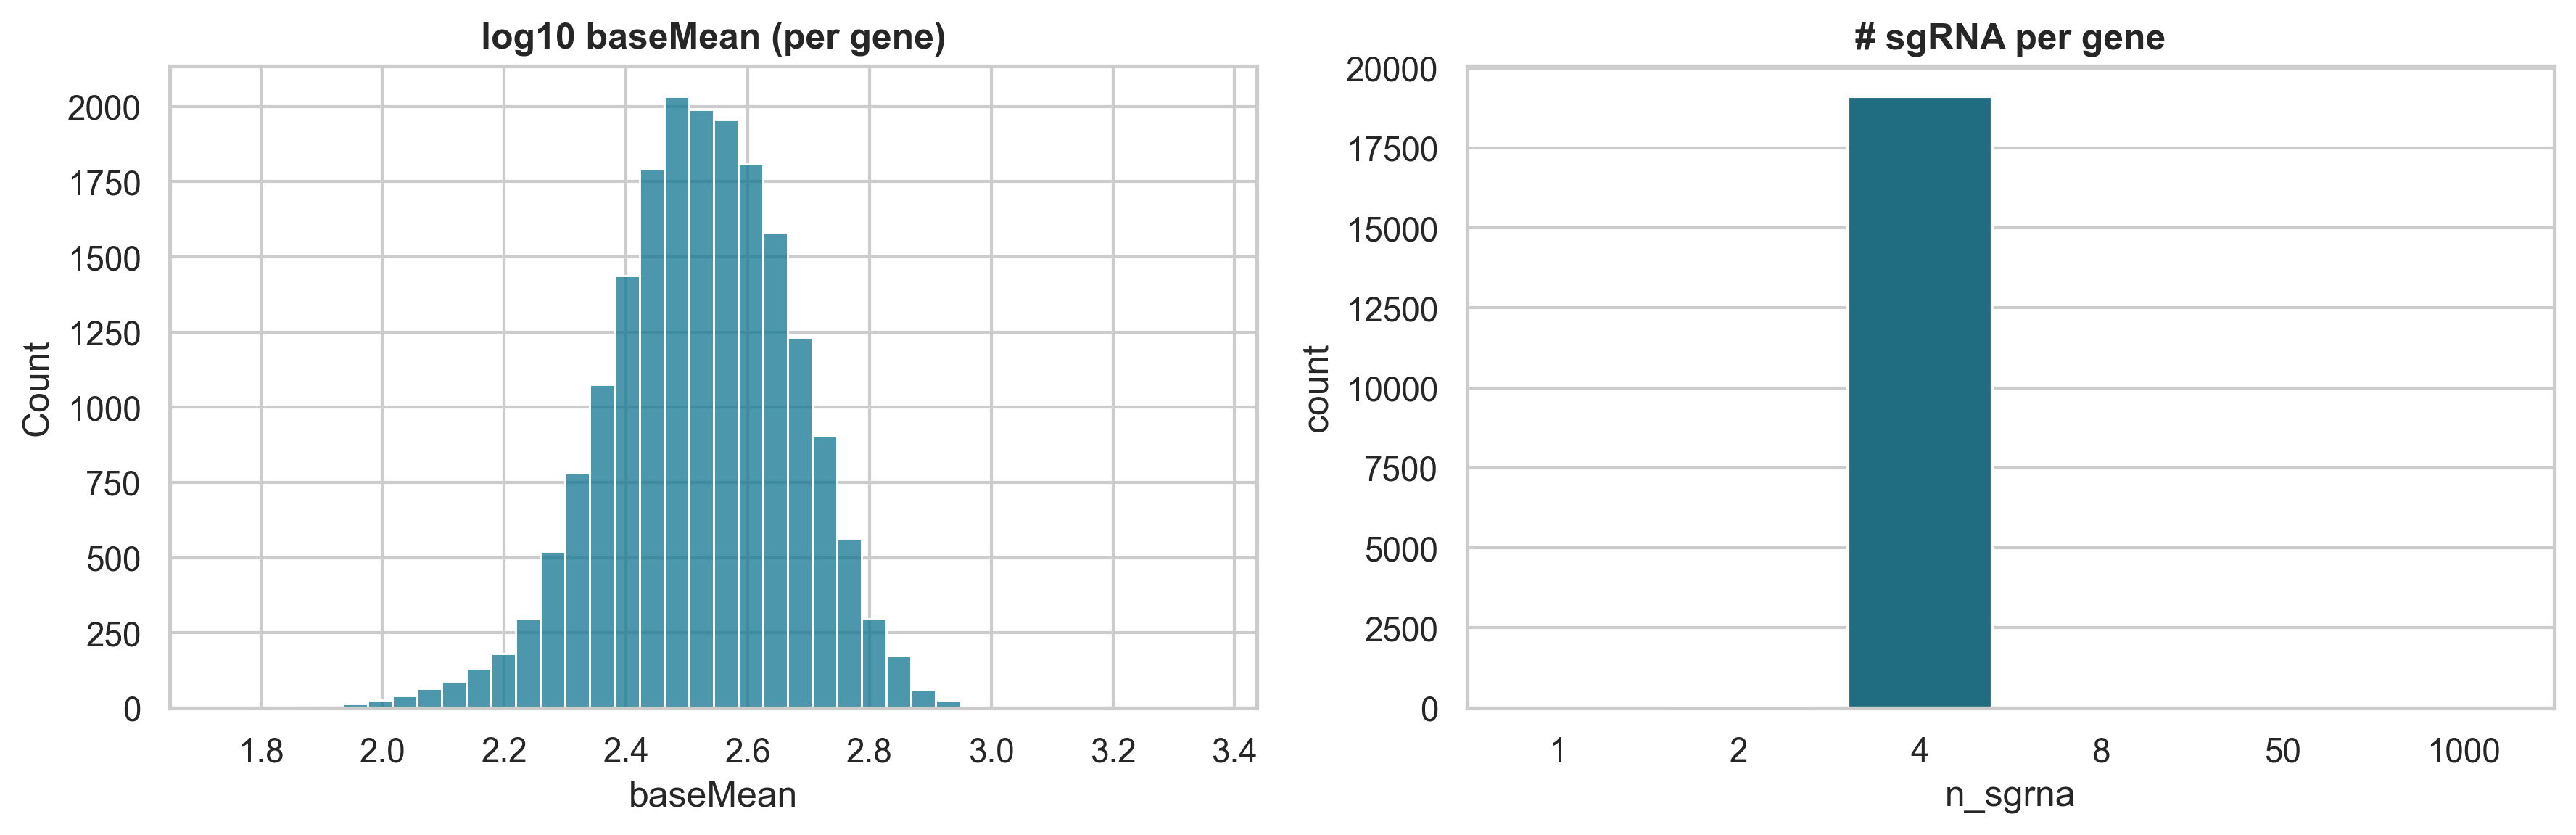

In [42]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(np.log10(qc['baseMean'] + 1e-6), bins=40, ax=ax[0])
ax[0].set_title('log10 baseMean (per gene)')
sns.countplot(x='n_sgrna', data=qc, ax=ax[1])
ax[1].set_title('# sgRNA per gene')
plt.tight_layout(); plt.show()

## 5) EB calibration (φ trend, τ scales)

In [6]:
def estimate_phi_per_gene(df: pd.DataFrame) -> pd.DataFrame:
    # Method-of-moments phi per gene using size-factor normalized counts.
    # NB2: Var = mu + mu^2/phi  =>  phi = mu^2 / (Var - mu).
    d = df.copy()
    y_sf = d['count'] / (d['size_factor'] + 1e-12)
    stats_g = (pd.DataFrame({'y_sf': y_sf, 'gene': d['gene']})
               .groupby('gene').agg(mu_g=('y_sf','mean'), var_g=('y_sf','var')))
    stats_g['var_g'] = stats_g['var_g'].fillna(0.0)
    eps = 1e-8
    denom = (stats_g['var_g'] - stats_g['mu_g']).clip(lower=eps)
    phi_hat = (stats_g['mu_g']**2 / denom).clip(lower=1e-3, upper=1e6)
    stats_g['phi_hat'] = phi_hat
    stats_g['baseMean'] = stats_g['mu_g']
    stats_g['log_bm'] = np.log(stats_g['baseMean'] + 1e-12)
    stats_g['log_phi_hat'] = np.log(stats_g['phi_hat'])
    return stats_g.reset_index()

def smooth_logphi_vs_logbm(phi_df: pd.DataFrame) -> dict:
    x = phi_df['log_bm'].to_numpy()
    y = phi_df['log_phi_hat'].to_numpy()
    # LOWESS smoothing
    smoothed = sm.nonparametric.lowess(y, x, frac=0.3, it=1, return_sorted=True)
    x_s, y_s = smoothed[:,0], smoothed[:,1]
    order = np.argsort(x_s)
    return {'x': x_s[order], 'y': y_s[order]}

def predict_phi_from_bm(bm_series: pd.Series, smooth_obj: dict) -> pd.Series:
    xq = np.log(bm_series.astype(float) + 1e-12).to_numpy()
    yq = np.interp(xq, smooth_obj['x'], smooth_obj['y'], left=smooth_obj['y'][0], right=smooth_obj['y'][-1])
    return pd.Series(np.exp(yq), index=bm_series.index, name='phi_eb')

def estimate_tau_scales(df: pd.DataFrame) -> dict:
    # tau_beta from robust gene-wise log fold-changes
    d = df.copy()
    d['y_sf'] = d['count'] / (d['size_factor'] + 1e-12)
    gxs = d.groupby(['gene','x'])['y_sf'].mean().unstack(fill_value=np.nan)
    # add pseudocount to stabilize
    lfc = np.log((gxs.get(1, pd.Series()) + 1e-3) / (gxs.get(0, pd.Series()) + 1e-3))
    lfc = lfc.replace([np.inf, -np.inf], np.nan).dropna()
    scale_beta = np.median(np.abs(lfc)) / 0.6745 if len(lfc) else 0.2
    scale_beta = float(np.clip(scale_beta, 0.05, 2.0))
    # tau_u from within-gene sgRNA variability (MAD on log y_sf)
    def per_gene_u_mad(sub: pd.DataFrame) -> float:
        tmp = sub.copy()
        tmp['log_y_sf'] = np.log(tmp['y_sf'] + 1e-3)
        m = tmp.groupby('sgrna')['log_y_sf'].mean()
        return float(mad(m.to_numpy()))
    u_scales = d.groupby('gene').apply(per_gene_u_mad)
    scale_u = float(np.clip(np.median(u_scales.to_numpy()) if len(u_scales) else 0.2, 0.05, 2.0))
    return {'tau_beta': scale_beta, 'tau_u': scale_u}

phi_df = estimate_phi_per_gene(df)
smooth = smooth_logphi_vs_logbm(phi_df)
phi_eb = predict_phi_from_bm(bm, smooth)
taus = estimate_tau_scales(df)

priors = {
    'tau_beta': taus['tau_beta'],
    'tau_u': taus['tau_u'],
    'phi_by_gene': phi_eb.to_dict(),
}
with open(NEL_PRIORS_JSON, 'w') as f:
    json.dump({'NEL': priors}, f, indent=2)

phi_df.head(), taus, list(phi_eb.head().items())[:3]

/var/folders/pr/h88b6g4501n71rccry8frf180000gn/T/ipykernel_95658/1109663039.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  u_scales = d.groupby('gene').apply(per_gene_u_mad)


(                  gene        mu_g         var_g    phi_hat    baseMean    log_bm  log_phi_hat
 0  2023-03-01 00:00:00  412.638216  50027.181805   3.431863  412.638216  6.022571     1.233103
 1  2023-03-02 00:00:00  282.275564  24734.847315   3.258532  282.275564  5.642884     1.181277
 2  2023-03-03 00:00:00  332.047295  10760.748082  10.572305  332.047295  5.805277     2.358238
 3  2023-03-04 00:00:00  360.547006  23820.941620   5.541004  360.547006  5.887622     1.712176
 4  2023-03-05 00:00:00  158.422785   5452.237064   4.740963  158.422785  5.065267     1.556240,
 {'tau_beta': 0.11427753071827036, 'tau_u': 0.3912933955794203},
 [('2023-03-01 00:00:00', 3.530484976213076),
  ('2023-03-02 00:00:00', 5.40777316023734),
  ('2023-03-03 00:00:00', 4.593550715007215)])

/var/folders/pr/h88b6g4501n71rccry8frf180000gn/T/ipykernel_95658/2607546414.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(); plt.show()


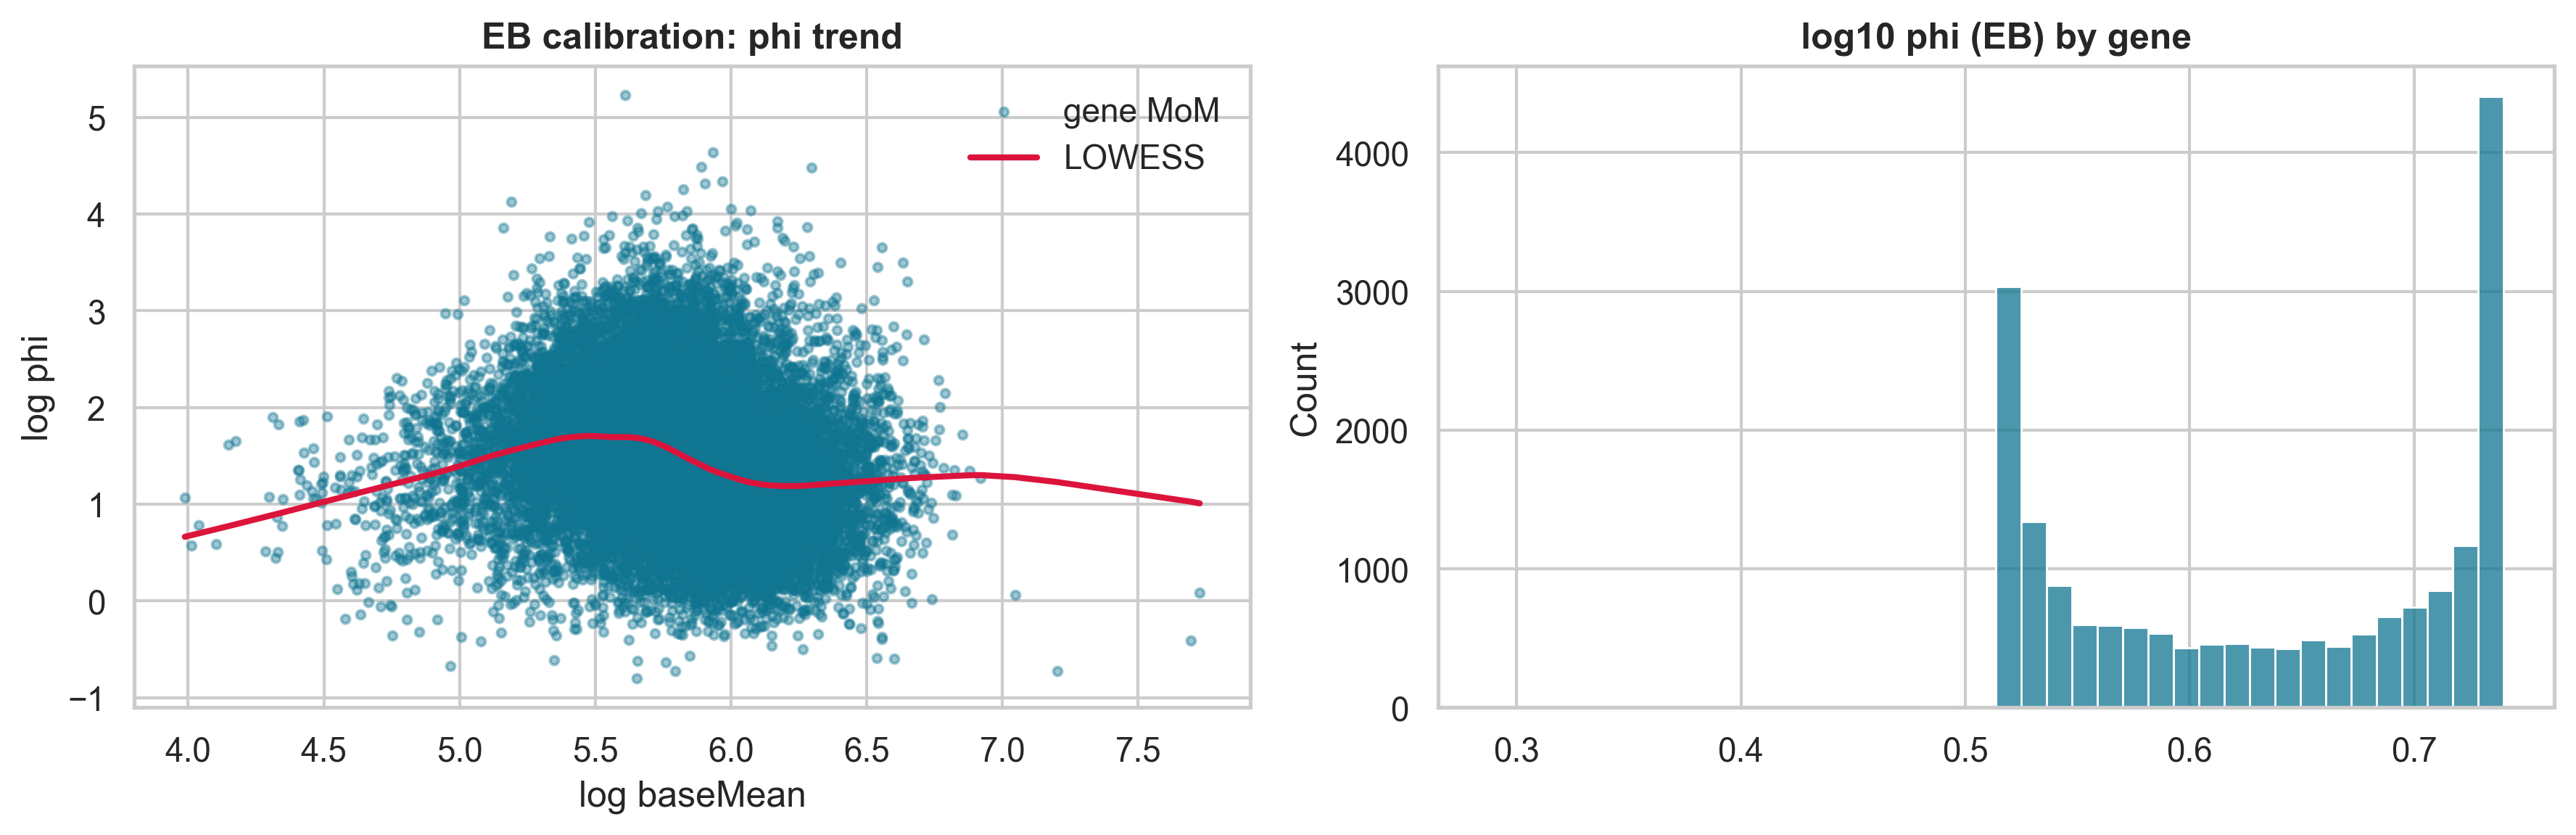

In [43]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(phi_df['log_bm'], phi_df['log_phi_hat'], s=8, alpha=0.4, label='gene MoM')
ax[0].plot(smooth['x'], smooth['y'], color='crimson', lw=2, label='LOWESS')
ax[0].set_xlabel('log baseMean')
ax[0].set_ylabel('log phi')
ax[0].legend()
ax[0].set_title('EB calibration: phi trend')
sns.histplot(np.log10(pd.Series(priors['phi_by_gene']).astype(float)+1e-12), bins=40, ax=ax[1])
ax[1].set_title('log10 phi (EB) by gene')
plt.tight_layout(); plt.show()

## 6) IRLS + Laplace per gene

In [45]:
# Stabilized IRLS + Laplace/ Gaussian prior option for NB2 update (2024-03)
def build_design(sub: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray, list[str]]:
    """Construct design matrix with intercept, treatment, and sgRNA effects."""
    x_t = sub['x_tilde'].to_numpy(float).reshape(-1, 1)
    intercept = np.ones((len(sub), 1), dtype=float)
    sg = sub['sgrna'].astype('category')
    levels = list(sg.cat.categories)
    ref = levels[-1] if levels else None
    dummies = pd.get_dummies(sg, drop_first=True).to_numpy(float)
    X = np.concatenate([intercept, x_t, dummies], axis=1)
    y = sub['count'].to_numpy(float)
    offset = sub['offset'].to_numpy(float)
    colnames = ['intercept', 'beta'] + [f'u[{lev}]' for lev in levels if lev != ref]
    return X, y, offset, colnames


def irls_nb2_map(
    X: np.ndarray,
    y: np.ndarray,
    offset: np.ndarray,
    phi: float,
    tau_beta: float,
    tau_u: float,
    max_iter: int = 25,
    tol: float = 1e-6,
    prior_beta: str = 'gaussian',  # 'gaussian' or 'laplace'
    l1_epsilon: float = 1e-3,
) -> dict:
    """IRLS solver with Laplace covariance for NB2 log-link model.

    prior_beta controls the prior on the treatment effect beta (column index 1):
    - 'gaussian':   beta ~ N(0, tau_beta^2)              → ridge penalty 1/tau_beta^2
    - 'laplace':    beta ~ Laplace(0, b), Var=2b^2       → L1 penalty |beta|/b
                    We implement LQA: replace |beta| by 0.5 * w * beta^2 with w = (sqrt(2)/tau_beta)/max(|beta|, eps)
    u effects remain Gaussian (ridge) with scale tau_u.
    """
    n, p = X.shape
    theta = np.zeros(p)

    tau_beta_safe = max(float(tau_beta), 1e-6)
    tau_u_safe = max(float(tau_u), 1e-6)
    jitter = 1e-8 * np.eye(p)

    converged = False
    for it in range(1, max_iter + 1):
        # Linear predictor and mean
        eta_raw = offset + X @ theta
        eta = np.clip(eta_raw, -25.0, 25.0)
        with np.errstate(over='ignore'):
            mu = np.exp(eta)
        mu_safe = np.clip(mu, 1e-12, 1e12)
        phi_safe = max(float(phi), 1e-6)

        # IRLS weights and working response for NB2 with log link
        w = mu_safe / (1.0 + (mu_safe / phi_safe))
        w = np.clip(w, 1e-12, 1e6)
        z = eta + (y - mu_safe) / mu_safe

        if not (np.all(np.isfinite(w)) and np.all(np.isfinite(z))):
            z = np.nan_to_num(z, nan=0.0, posinf=25.0, neginf=-25.0)
            w = np.nan_to_num(w, nan=phi_safe, posinf=1e6, neginf=1e-12)

        # Weighted normal equations
        WX = X * w[:, None]
        XTWX = X.T @ WX
        XTWz = X.T @ (w * (z - offset))

        # Penalty matrix: intercept unpenalized; beta gets Gaussian or Laplace-LQA; u's ridge
        lam = np.zeros(p)
        if p >= 2:
            if prior_beta.lower() == 'laplace':
                # Laplace scale b = tau_beta / sqrt(2) ⇒ λ_l1 = 1/b = sqrt(2)/tau_beta
                lam_l1 = np.sqrt(2.0) / tau_beta_safe
                # Local quadratic approx: |beta| ≈ 0.5 * (lam_l1 / max(|beta|, eps)) * beta^2
                lam[1] = lam_l1 / max(abs(theta[1]), l1_epsilon)
            else:
                lam[1] = 1.0 / (tau_beta_safe ** 2)
        if p > 2:
            lam[2:] = 1.0 / (tau_u_safe ** 2)
        lam_mat = np.diag(lam)

        # Solve penalized system
        try:
            theta_new = linalg.solve(XTWX + lam_mat + jitter, XTWz, assume_a='pos')
        except linalg.LinAlgError:
            theta_new = linalg.lstsq(XTWX + lam_mat + jitter, XTWz)[0]

        if not np.all(np.isfinite(theta_new)):
            theta_new = np.nan_to_num(theta_new, nan=0.0, posinf=50.0, neginf=-50.0)

        if np.max(np.abs(theta_new - theta)) < tol:
            theta = theta_new
            converged = True
            break
        theta = theta_new

    # Final covariance from the last quadratic approx
    eta = np.clip(offset + X @ theta, -25.0, 25.0)
    with np.errstate(over='ignore'):
        mu = np.exp(eta)
    mu_safe = np.clip(mu, 1e-12, 1e12)
    phi_safe = max(float(phi), 1e-6)
    w = mu_safe / (1.0 + (mu_safe / phi_safe))
    w = np.clip(w, 1e-12, 1e6)
    WX = X * w[:, None]

    lam = np.zeros(p)
    if p >= 2:
        if prior_beta.lower() == 'laplace':
            lam_l1 = np.sqrt(2.0) / tau_beta_safe
            lam[1] = lam_l1 / max(abs(theta[1]), l1_epsilon)
        else:
            lam[1] = 1.0 / (tau_beta_safe ** 2)
    if p > 2:
        lam[2:] = 1.0 / (tau_u_safe ** 2)
    lam_mat = np.diag(lam)

    H = X.T @ WX + lam_mat + jitter
    try:
        cov = linalg.inv(H)
    except linalg.LinAlgError:
        cov = linalg.pinv(H)
    return {'theta': theta, 'cov': cov, 'converged': converged, 'iters': it}


def posterior_metrics_beta(
    theta: np.ndarray, cov: np.ndarray, beta_idx: int = 1, delta: float = 0.22
) -> dict:
    m = float(theta[beta_idx])
    sd = float(np.sqrt(max(cov[beta_idx, beta_idx], 1e-12)))
    p_pos = 1.0 - stats.norm.cdf(0.0, loc=m, scale=sd)
    p_neg = stats.norm.cdf(0.0, loc=m, scale=sd)
    lfsr = float(min(p_pos, p_neg))
    p_eff = float(
        (1.0 - stats.norm.cdf(delta, loc=m, scale=sd))
        + stats.norm.cdf(-delta, loc=m, scale=sd)
    )
    return {'beta_mean': m, 'beta_sd': sd, 'lfsr': lfsr, 'p_effect_ge_delta': p_eff}


def fit_all_genes(
    df: pd.DataFrame,
    phi_map: dict,
    tau_beta: float,
    tau_u: float,
    delta: float = 0.22,
    prior_beta: str = 'gaussian',
) -> pd.DataFrame:
    phi_values = np.array([
        float(v) for v in phi_map.values() if np.isfinite(v) and v > 0
    ])
    phi_default = float(np.median(phi_values)) if phi_values.size else 1.0

    out = []
    for g, sub in df.groupby('gene'):
        X, y, offset, cols = build_design(sub)
        phi_raw = phi_map.get(g, np.nan)
        if not np.isfinite(phi_raw) or phi_raw <= 0:
            phi = phi_default
        else:
            phi = float(phi_raw)
        res = irls_nb2_map(
            X, y, offset, phi, tau_beta, tau_u, prior_beta=prior_beta
        )
        mets = posterior_metrics_beta(res['theta'], res['cov'], beta_idx=1, delta=delta)
        out.append({
            'gene': g,
            'converged': res['converged'],
            'iters': res['iters'],
            'phi': phi,
            **mets,
        })
    return pd.DataFrame(out)


# Use Laplace prior for beta by default; switch back to 'gaussian' if desired
gene_summary = fit_all_genes(
    df, priors['phi_by_gene'], priors['tau_beta'], priors['tau_u'], delta=0.22, prior_beta='laplace'
)
gene_summary.sort_values('lfsr').head()

,gene,converged,iters,phi,beta_mean,beta_sd,lfsr,p_effect_ge_delta
6012,FOXP3,False,25,3.413720,2.059690,0.076596,1.425013e-159,1.0
4130,DAD1,False,25,4.420683,2.358451,0.236164,8.731354e-24,1.0
15263,SMARCB1,False,25,2.785618,2.247212,0.287028,2.454014e-15,1.0
15248,SMAD3,False,25,3.477074,1.856308,0.258163,3.228989e-13,1.0
16465,TGFBR1,False,25,3.475501,1.825676,0.257961,7.348048e-13,1.0


## 7) Diagnostics

converged
False        19106
True             7
Name: count, dtype: int64


/var/folders/pr/h88b6g4501n71rccry8frf180000gn/T/ipykernel_95658/2918507900.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


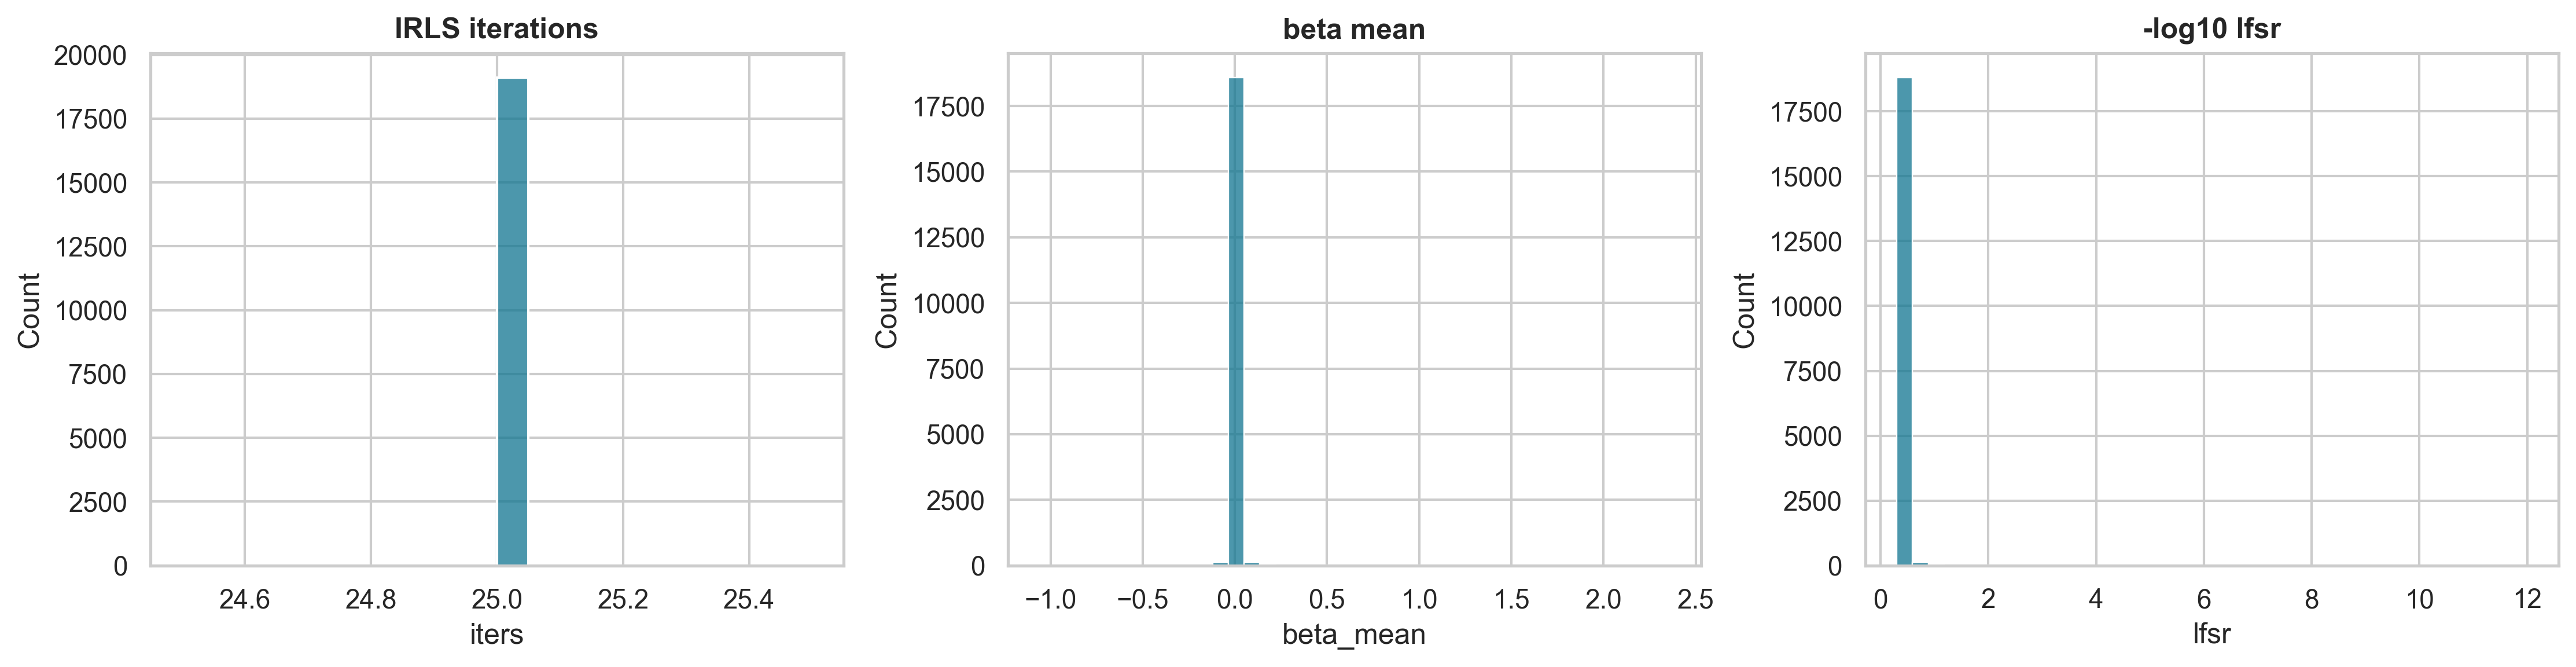

In [46]:
print(gene_summary[['converged']].value_counts())

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(gene_summary['iters'], bins=20, ax=ax[0])
ax[0].set_title('IRLS iterations')
sns.histplot(gene_summary['beta_mean'], bins=40, ax=ax[1])
ax[1].set_title('beta mean')
sns.histplot(-np.log10(gene_summary['lfsr'] + 1e-12), bins=40, ax=ax[2])
ax[2].set_title('-log10 lfsr')
plt.tight_layout()
plt.show()

## 8) Hit-calling

In [80]:
# Hit calling aligned with HBM tier rules (normal approx)
PROB_MIN = 0.8
TIER1_THRESH = 0.5
TIER2_THRESH = 0.3

beta = pd.to_numeric(gene_summary['beta_mean'], errors='coerce').to_numpy()
sd = np.clip(pd.to_numeric(gene_summary['beta_sd'], errors='coerce').to_numpy(), 1e-12, np.inf)

def p_abs_ge(thresh: float) -> np.ndarray:
    z_pos = (thresh - beta) / sd
    z_neg = (-thresh - beta) / sd
    p_pos = stats.norm.sf(z_pos)
    p_neg = stats.norm.cdf(z_neg)
    return np.clip(p_pos + p_neg, 0.0, 1.0)

gene_summary['p_abs_beta_ge_0_3_norm'] = p_abs_ge(TIER2_THRESH)
gene_summary['p_abs_beta_ge_0_5_norm'] = p_abs_ge(TIER1_THRESH)
gene_summary['neglog10_lfsr'] = -np.log10(np.clip(pd.to_numeric(gene_summary['lfsr'], errors='coerce'), 1e-300, 1.0) + 1e-20)

tier1 = gene_summary['p_abs_beta_ge_0_5_norm'] >= PROB_MIN
tier2 = (gene_summary['p_abs_beta_ge_0_3_norm'] >= PROB_MIN) & (~tier1)
gene_summary['hit_tier1'] = tier1
gene_summary['hit_tier2'] = tier2
gene_summary['hit_any'] = tier1 | tier2

cat = np.full(len(gene_summary), 'none', dtype=object)
beta_pos = beta >= 0
tier1_mask = tier1.to_numpy()
tier2_mask = tier2.to_numpy()
cat[np.logical_and(tier2_mask, beta_pos)] = 'tier2_pos'
cat[np.logical_and(tier2_mask, ~beta_pos)] = 'tier2_neg'
cat[np.logical_and(tier1_mask, beta_pos)] = 'tier1_pos'
cat[np.logical_and(tier1_mask, ~beta_pos)] = 'tier1_neg'
gene_summary['hit_category'] = cat

hits = gene_summary.loc[gene_summary['hit_any']].copy()
hits = hits.sort_values(
    ['hit_tier1', 'p_abs_beta_ge_0_5_norm', 'p_abs_beta_ge_0_3_norm', 'neglog10_lfsr'],
    ascending=[False, False, False, False]
)
hits.to_csv(NEL_HITS_CSV, index=False)
gene_summary.to_csv(NEL_SUMMARY_CSV, index=False)

print(f"Tier1 hits (|beta|≥{TIER1_THRESH}, P≥{PROB_MIN}): {int(tier1.sum())}")
print(f"Tier2 hits (|beta|≥{TIER2_THRESH}, P≥{PROB_MIN}, excl tier1): {int(tier2.sum())}")
print(f"Hit table saved to: {NEL_HITS_CSV}")
print(f"Gene summary saved to: {NEL_SUMMARY_CSV}")

hits.head(10)

Tier1 hits (|beta|≥0.5, P≥0.8): 45
Tier2 hits (|beta|≥0.3, P≥0.8, excl tier1): 29
Hit table saved to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_nel.csv
Gene summary saved to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/nel_gene_summary.csv


,gene,converged,iters,phi,beta_mean,beta_sd,lfsr,p_effect_ge_delta,p_abs_beta_ge_0_3_norm,p_abs_beta_ge_0_5_norm,neglog10_lfsr,hit_tier1,hit_tier2,hit_any,hit_category
6012,FOXP3,False,25,3.413720,2.059690,0.076596,1.425013e-159,1.0,1.000000,1.000000,20.000000,True,False,True,tier1_pos
4130,DAD1,False,25,4.420683,2.358451,0.236164,8.731354e-24,1.0,1.000000,1.000000,19.999621,True,False,True,tier1_pos
15263,SMARCB1,False,25,2.785618,2.247212,0.287028,2.454014e-15,1.0,1.000000,1.000000,14.610121,True,False,True,tier1_pos
15248,SMAD3,False,25,3.477074,1.856308,0.258163,3.228989e-13,1.0,1.000000,1.000000,12.490933,True,False,True,tier1_pos
16465,TGFBR1,False,25,3.475501,1.825676,0.257961,7.348048e-13,1.0,1.000000,1.000000,12.133828,True,False,True,tier1_pos
16466,TGFBR2,False,25,3.428541,1.715240,0.258723,1.682509e-11,1.0,1.000000,0.999999,10.774043,True,False,True,tier1_pos
14064,RPN1,False,25,3.519151,1.598541,0.254791,1.760210e-10,1.0,1.000000,0.999992,9.754435,True,False,True,tier1_pos
15249,SMAD4,False,25,3.443828,1.559261,0.257509,7.013239e-10,1.0,0.999999,0.999981,9.154081,True,False,True,tier1_pos
17798,USO1,False,25,3.556612,1.503416,0.252548,1.316378e-09,1.0,0.999999,0.999965,8.880619,True,False,True,tier1_pos
2791,CD3D,False,25,4.669915,1.344532,0.223736,9.307458e-10,1.0,0.999998,0.999920,9.031169,True,False,True,tier1_pos


## 9) Volcano plot

/var/folders/pr/h88b6g4501n71rccry8frf180000gn/T/ipykernel_95658/2652982454.py:46: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Saved volcano figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/volcano_nel_tiered.png


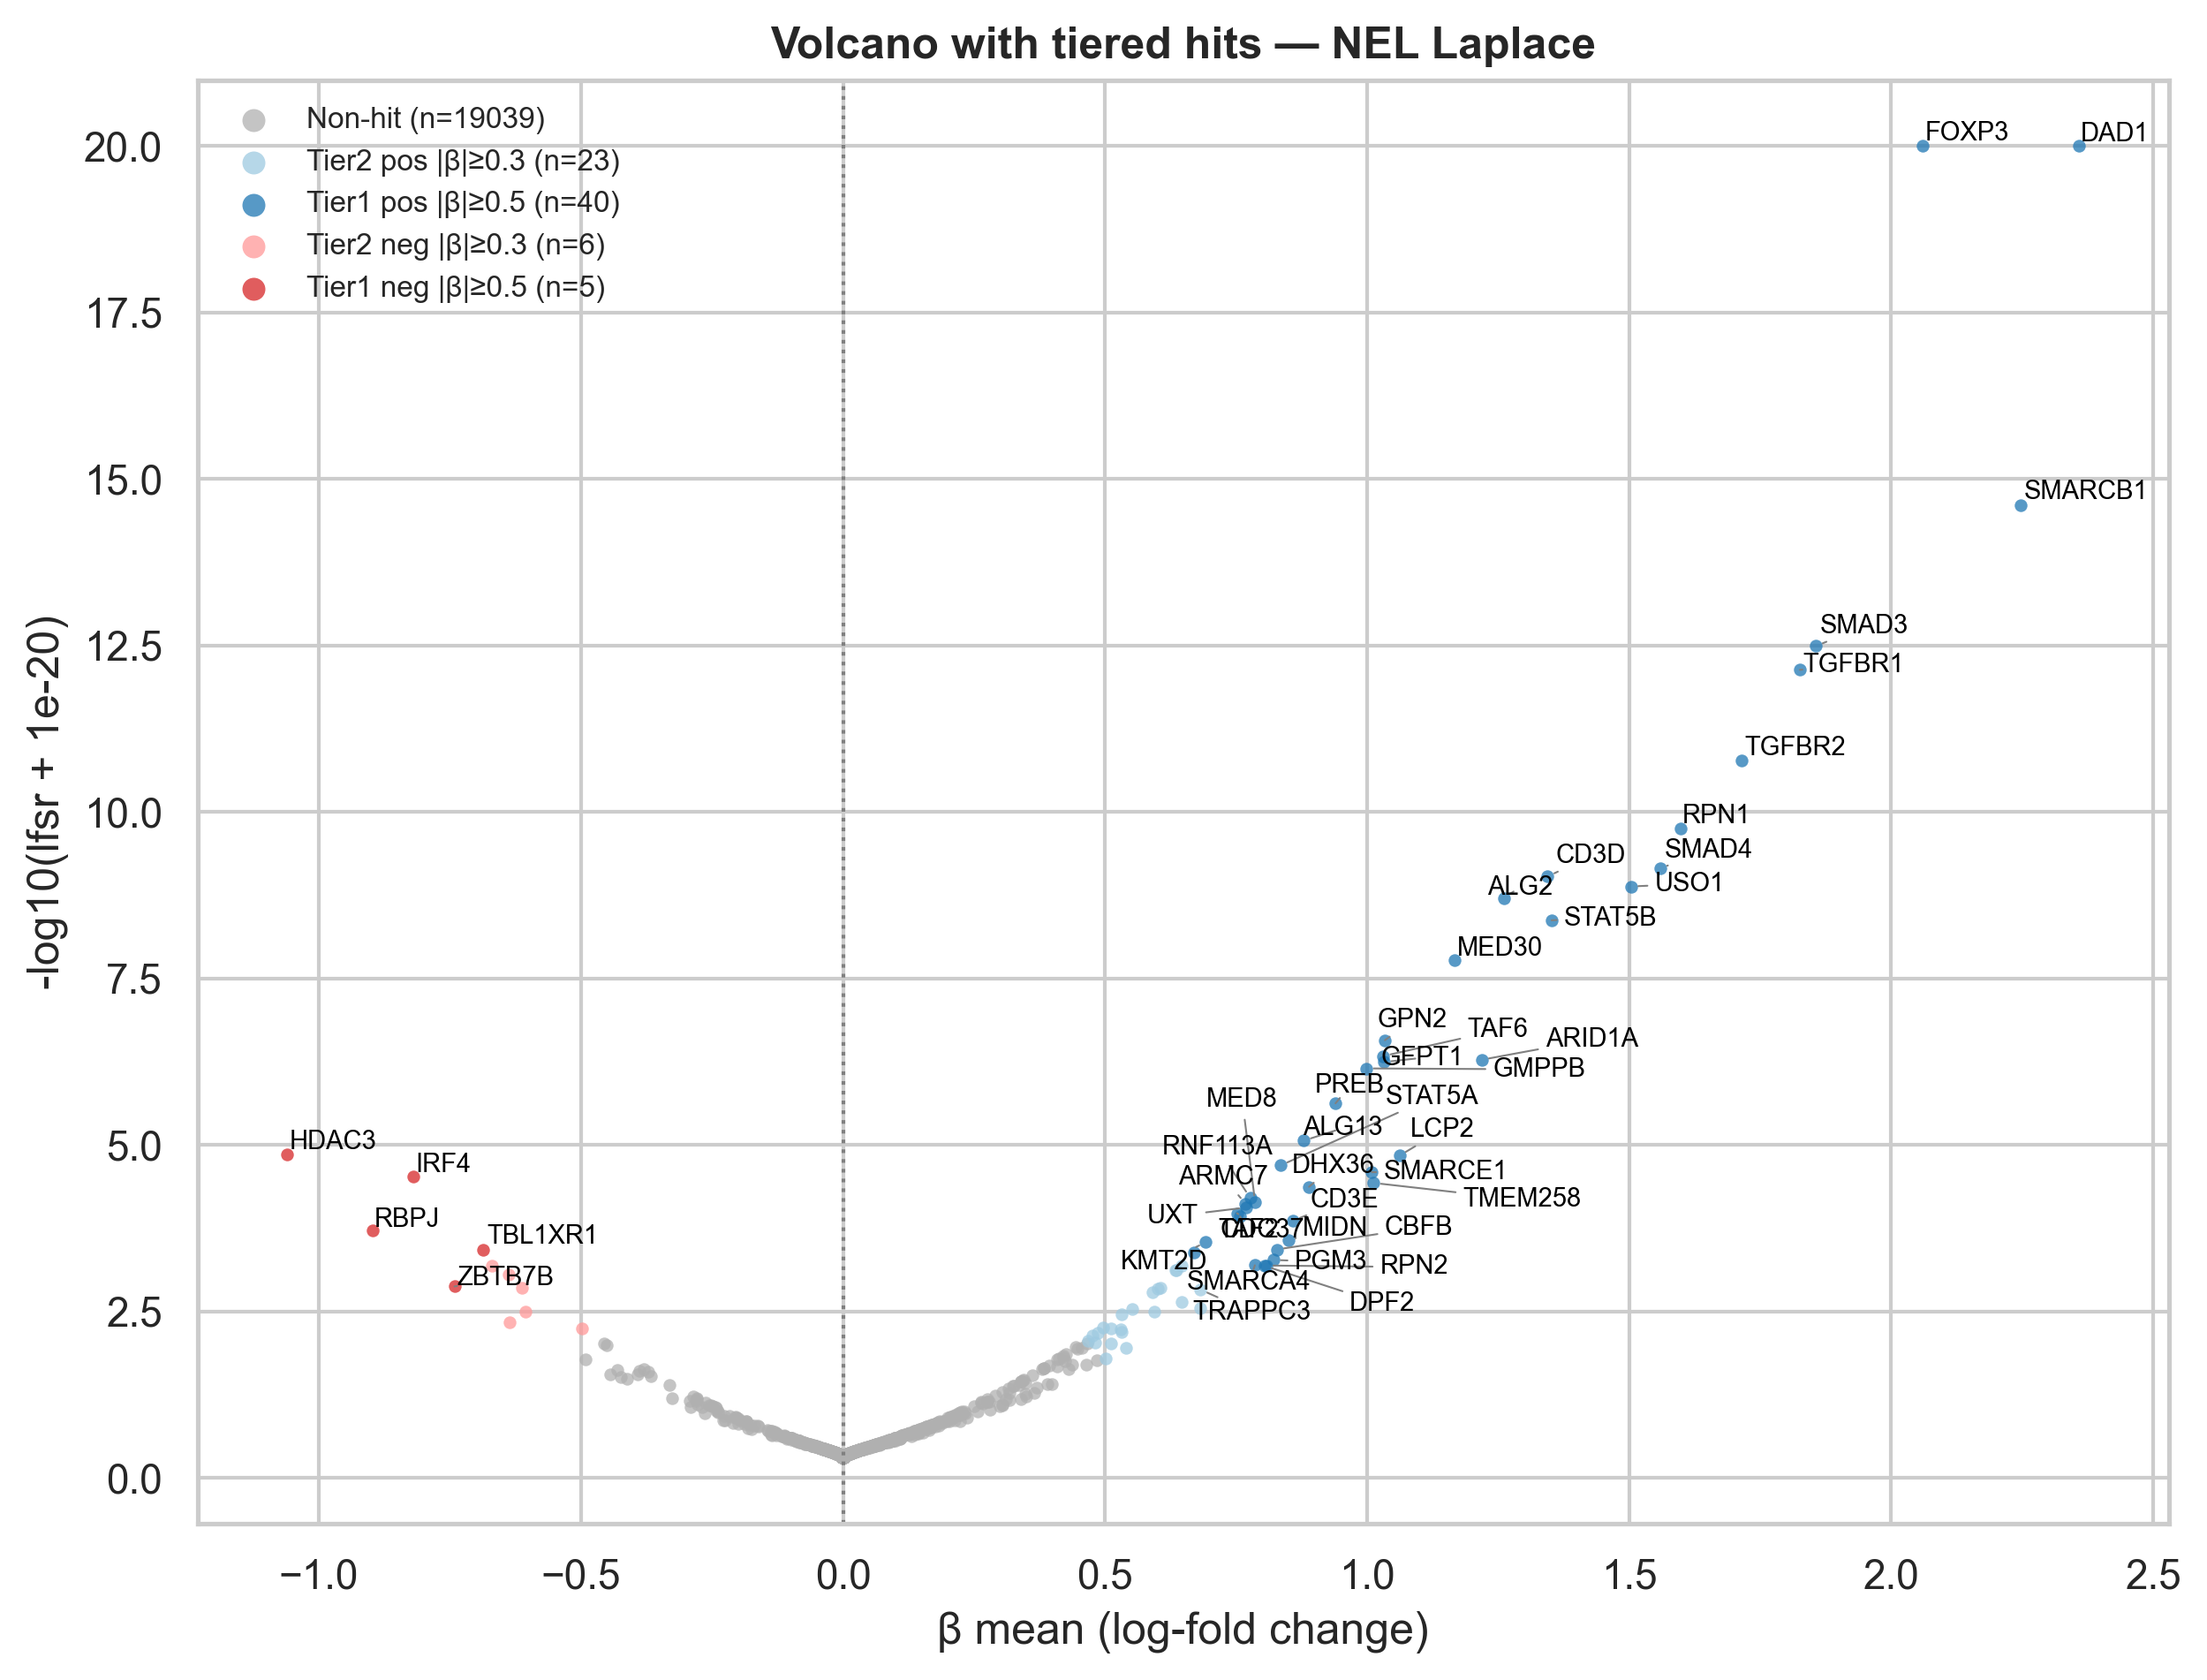

Tier1 hits plotted: 45
Tier2 hits plotted: 29
Non-hits plotted: 19039


In [ ]:
# Volcano plot with tiered hit styling (matches HBM notebook)
color_map = {
    'none': '#B0B0B0',
    'tier2_pos': '#9ecae1',
    'tier1_pos': '#1f77b4',
    'tier2_neg': '#ff9999',
    'tier1_neg': '#d62728',
}

plot_df = gene_summary[['gene', 'beta_mean', 'neglog10_lfsr', 'hit_tier1', 'hit_tier2', 'hit_category']].copy()

plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['beta_mean', 'neglog10_lfsr'])
plot_df['hit_tier1'] = plot_df['hit_tier1'].fillna(False)
plot_df['hit_tier2'] = plot_df['hit_tier2'].fillna(False)
plot_df['hit_category'] = plot_df['hit_category'].fillna('none')
plot_df['beta_mean_abs'] = plot_df['beta_mean'].abs()

fig, ax = plt.subplots(figsize=(8.5, 6.5))
order = ['none', 'tier2_pos', 'tier1_pos', 'tier2_neg', 'tier1_neg']
for key in order:
    sub = plot_df[plot_df['hit_category'] == key]
    if sub.empty:
        continue
    label = {
        'none': f"Non-hit (n={len(sub)})",
        'tier2_pos': f"Tier2 pos |β|≥0.3 (n={len(sub)})",
        'tier1_pos': f"Tier1 pos |β|≥0.5 (n={len(sub)})",
        'tier2_neg': f"Tier2 neg |β|≥0.3 (n={len(sub)})",
        'tier1_neg': f"Tier1 neg |β|≥0.5 (n={len(sub)})",
    }[key]
    ax.scatter(
        pd.to_numeric(sub['beta_mean'], errors='coerce'),
        pd.to_numeric(sub['neglog10_lfsr'], errors='coerce'),
        c=color_map[key],
        s=12,
        alpha=0.75,
        linewidths=0,
        label=label,
    )

ax.axvline(0, color='gray', linestyle=':', linewidth=1)
ax.set_xlabel('β mean (log-fold change)')
ax.set_ylabel('-log10(lfsr + 1e-20)')
ax.set_title('Volcano with tiered hits — NEL Laplace')
ax.legend(frameon=False, markerscale=1.8, fontsize=8, loc='best')
fig.tight_layout()

texts = []
if 'gene' in plot_df.columns and not plot_df.empty:
    top = plot_df.nlargest(min(int(plot_df['hit_tier1'].sum()), len(plot_df)), 'beta_mean_abs')
    for _, row in top.iterrows():
        texts.append(ax.text(row['beta_mean'], row['neglog10_lfsr'], row['gene'], fontsize=7, color='black'))
    if texts:
        try:
            from adjustText import adjust_text
            adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
        except Exception:
            pass

fig_path = OUT_FIGS / 'volcano_nel_tiered.png'
fig.savefig(fig_path, dpi=200, bbox_inches='tight')
print(f"Saved volcano figure: {fig_path}")
plt.show()

n_t1 = int(plot_df['hit_tier1'].sum())
n_t2 = int(plot_df['hit_tier2'].sum())
n_none = int((plot_df['hit_category'] == 'none').sum())
print(f"Tier1 hits plotted: {n_t1}")
print(f"Tier2 hits plotted: {n_t2}")
print(f"Non-hits plotted: {n_none}")

In [81]:
# Compare hits between NEL (Laplace) and HBM NUTS
import pandas as pd
from pathlib import Path

nel_hits_path = NEL_HITS_CSV if 'NEL_HITS_CSV' in globals() else (OUT_TABLES / 'hits_nel.csv')
nuts_hits_path = OUT_TABLES / 'hits_hbm_nuts.csv'

assert Path(nel_hits_path).exists(), f"Missing NEL hits CSV: {nel_hits_path}"
assert Path(nuts_hits_path).exists(), f"Missing HBM NUTS hits CSV: {nuts_hits_path}"

def _gene_col(df: pd.DataFrame) -> str:
    for c in ['gene','Gene','id','ID','gene_symbol','GeneSymbol','label','name']:
        if c in df.columns:
            return c
    raise ValueError('No gene-like column found in hits table')

def _hit_mask(df: pd.DataFrame) -> pd.Series:
    # Return a boolean mask selecting rows flagged as hits when a hit column exists.
    # If no hit-like column exists, return all True.
    cand = ['hit', 'hit_any', 'is_hit', 'hit_tier1', 'hit_tier2']
    for c in cand:
        if c in df.columns:
            s = df[c]
            if s.dtype == bool:
                return s.fillna(False)
            # Accept common string/numeric encodings of booleans
            vals = s.astype(str).str.strip().str.lower()
            return vals.isin(['true','1','t','yes'])
    return pd.Series(True, index=df.index)

nel_df = pd.read_csv(nel_hits_path)
nuts_df = pd.read_csv(nuts_hits_path)

# Filter to true hits if a hit flag exists in either table
nel_df = nel_df[_hit_mask(nel_df)].copy()
nuts_df = nuts_df[_hit_mask(nuts_df)].copy()

g_nel = _gene_col(nel_df)
g_nuts = _gene_col(nuts_df)

nel_genes = nel_df[g_nel].astype(str).str.strip()
nuts_genes = nuts_df[g_nuts].astype(str).str.strip()

set_nel = set(nel_genes)
set_nuts = set(nuts_genes)

common = sorted(set_nel & set_nuts)
nel_only = sorted(set_nel - set_nuts)
nuts_only = sorted(set_nuts - set_nel)

print(f"Common hits: {len(common)}")
print(f"NEL-only hits: {len(nel_only)}")
print(f"HBM NUTS-only hits: {len(nuts_only)}")

# Save an overlap table for downstream analysis
overlap = pd.DataFrame({'gene': sorted(set_nel | set_nuts)})
overlap['in_nel'] = overlap['gene'].isin(set_nel)
overlap['in_hbm_nuts'] = overlap['gene'].isin(set_nuts)
overlap_path = OUT_TABLES / 'hits_overlap_nel_hbm.csv'
overlap.to_csv(overlap_path, index=False)
print(f"Saved overlap table: {overlap_path}")

# Quick previews
display(pd.DataFrame({'gene': common}).head(20))
display(pd.DataFrame({'gene': nel_only}).head(20))
display(pd.DataFrame({'gene': nuts_only}).head(20))

Common hits: 74
NEL-only hits: 0
HBM NUTS-only hits: 174
Saved overlap table: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_overlap_nel_hbm.csv


,gene
0,ALDOA
1,ALG1
2,ALG13
3,ALG2
4,ANKRD17
5,ARID1A
6,ARMC7
7,BCL11B
8,BRK1
9,CBFB


,gene


,gene
0,AIP
1,ALG11
2,AMD1
3,APH1A
4,ARHGEF1
5,ARIH1
6,BAZ1B
7,BPTF
8,BRPF1
9,C16orf72


In [82]:
# Compare hits between NEL (Laplace) and MAGeCK benchmark
import pandas as pd
from pathlib import Path

nel_hits_path = NEL_HITS_CSV if 'NEL_HITS_CSV' in globals() else (OUT_TABLES / 'hits_nel.csv')
mageck_hits_path = OUT_TABLES / 'bench_mageck_hits.csv'

assert Path(nel_hits_path).exists(), f"Missing NEL hits CSV: {nel_hits_path}"
assert Path(mageck_hits_path).exists(), f"Missing MAGeCK hits CSV: {mageck_hits_path}"

def _gene_col(df: pd.DataFrame) -> str:
    for c in ['gene','Gene','id','ID','gene_symbol','GeneSymbol','label','name']:
        if c in df.columns:
            return c
    raise ValueError('No gene-like column found in hits table')

def _hit_mask(df: pd.DataFrame) -> pd.Series:
    # Return a boolean mask selecting rows flagged as hits when a hit column exists.
    cand = ['hit', 'hit_any', 'is_hit', 'hit_tier1', 'hit_tier2']
    for c in cand:
        if c in df.columns:
            s = df[c]
            if s.dtype == bool:
                return s.fillna(False)
            vals = s.astype(str).str.strip().str.lower()
            return vals.isin(['true','1','t','yes'])
    return pd.Series(True, index=df.index)

nel_df = pd.read_csv(nel_hits_path)
mageck_df = pd.read_csv(mageck_hits_path)

# Filter to true hits if a hit flag exists
nel_df = nel_df[_hit_mask(nel_df)].copy()
mageck_df = mageck_df[_hit_mask(mageck_df)].copy()

g_nel = _gene_col(nel_df)
g_mgk = _gene_col(mageck_df)

nel_genes = nel_df[g_nel].astype(str).str.strip()
mgk_genes = mageck_df[g_mgk].astype(str).str.strip()

set_nel = set(nel_genes)
set_mgk = set(mgk_genes)

common = sorted(set_nel & set_mgk)
nel_only = sorted(set_nel - set_mgk)
mgk_only = sorted(set_mgk - set_nel)

print(f"Common hits (NEL ∩ MAGeCK): {len(common)}")
print(f"NEL-only hits: {len(nel_only)}")
print(f"MAGeCK-only hits: {len(mgk_only)}")

# Save an overlap table for downstream analysis
overlap = pd.DataFrame({'gene': sorted(set_nel | set_mgk)})
overlap['in_nel'] = overlap['gene'].isin(set_nel)
overlap['in_mageck'] = overlap['gene'].isin(set_mgk)
overlap_path = OUT_TABLES / 'hits_overlap_nel_mageck.csv'
overlap.to_csv(overlap_path, index=False)
print(f"Saved overlap table: {overlap_path}")

# Quick previews
display(pd.DataFrame({'gene': common}).head(20))
display(pd.DataFrame({'gene': nel_only}).head(20))
display(pd.DataFrame({'gene': mgk_only}).head(20))

Common hits (NEL ∩ MAGeCK): 74
NEL-only hits: 0
MAGeCK-only hits: 165
Saved overlap table: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_overlap_nel_mageck.csv


,gene
0,ALDOA
1,ALG1
2,ALG13
3,ALG2
4,ANKRD17
5,ARID1A
6,ARMC7
7,BCL11B
8,BRK1
9,CBFB


,gene


,gene
0,AIP
1,ALG11
2,APH1A
3,AQP3
4,ARHGEF1
5,ARID4B
6,ARIH1
7,ARIH2
8,BAZ1B
9,BCL7B
